In [1]:
from datetime import datetime
from pandas import read_csv
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('data/poll.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


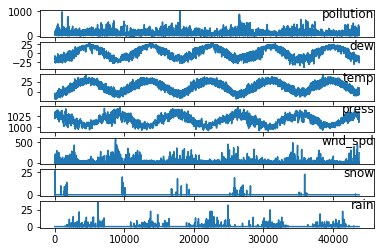

In [2]:

from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [3]:
from sklearn.preprocessing import LabelEncoder
from pandas import DataFrame, concat
from sklearn.preprocessing import MinMaxScaler

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()

In [4]:
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [5]:
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)


In [6]:
train_X.shape

(8760, 1, 8)

Train on 8760 samples, validate on 35039 samples
Epoch 1/50
 - 2s - loss: 0.0554 - val_loss: 0.0598
Epoch 2/50
 - 1s - loss: 0.0380 - val_loss: 0.0622
Epoch 3/50
 - 1s - loss: 0.0237 - val_loss: 0.0524
Epoch 4/50
 - 1s - loss: 0.0179 - val_loss: 0.0449
Epoch 5/50
 - 1s - loss: 0.0159 - val_loss: 0.0287
Epoch 6/50
 - 1s - loss: 0.0152 - val_loss: 0.0200
Epoch 7/50
 - 1s - loss: 0.0148 - val_loss: 0.0188
Epoch 8/50
 - 1s - loss: 0.0148 - val_loss: 0.0171
Epoch 9/50
 - 1s - loss: 0.0148 - val_loss: 0.0159
Epoch 10/50
 - 1s - loss: 0.0147 - val_loss: 0.0153
Epoch 11/50
 - 1s - loss: 0.0147 - val_loss: 0.0150
Epoch 12/50
 - 1s - loss: 0.0146 - val_loss: 0.0149
Epoch 13/50
 - 1s - loss: 0.0147 - val_loss: 0.0148
Epoch 14/50
 - 1s - loss: 0.0146 - val_loss: 0.0148
Epoch 15/50
 - 1s - loss: 0.0146 - val_loss: 0.0145
Epoch 16/50
 - 1s - loss: 0.0145 - val_loss: 0.0144
Epoch 17/50
 - 1s - loss: 0.0145 - val_loss: 0.0144
Epoch 18/50
 - 1s - loss: 0.0146 - val_loss: 0.0144
Epoch 19/50
 - 1s - loss

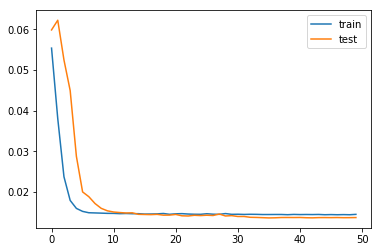

In [23]:
from keras import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [7]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

In [8]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

NameError: name 'model' is not defined

In [ ]:
#  New One Starts Here

In [63]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 50
n_hours_out_m = 50
n_hours_out = 1
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_hours_out)
reframed_m = series_to_supervised(scaled, n_hours, n_hours_out_m)

print(reframed.shape)
 
    
reframed = reframed.iloc[:-n_hours_out_m+1,:]

# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features] # n_obs?
test_X, test_y = test[:, :n_obs], test[:, -n_features]

# Train Multi

values = reframed_m.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features

train_y_m =  train[:, -n_obs:]
test_y_m =test[:, -n_obs:]

print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(43750, 408)
(8760, 400) 8760 (8760,)
(8760, 50, 8) (8760,) (34941, 50, 8) (34941,)


Train on 8760 samples, validate on 34270 samples
Epoch 1/20
 - 78s - loss: 0.0856 - val_loss: 0.0786
Epoch 2/20
 - 63s - loss: 0.0717 - val_loss: 0.0625
Epoch 3/20
 - 57s - loss: 0.0603 - val_loss: 0.0514
Epoch 4/20
 - 60s - loss: 0.0521 - val_loss: 0.0505
Epoch 5/20
 - 57s - loss: 0.0540 - val_loss: 0.0455
Epoch 6/20
 - 57s - loss: 0.0441 - val_loss: 0.0355
Epoch 7/20
 - 61s - loss: 0.0394 - val_loss: 0.0377
Epoch 8/20
 - 57s - loss: 0.0385 - val_loss: 0.0362
Epoch 9/20
 - 56s - loss: 0.0391 - val_loss: 0.0373
Epoch 10/20
 - 57s - loss: 0.0416 - val_loss: 0.0403
Epoch 11/20
 - 58s - loss: 0.0355 - val_loss: 0.0313
Epoch 12/20
 - 56s - loss: 0.0337 - val_loss: 0.0313
Epoch 13/20
 - 61s - loss: 0.0333 - val_loss: 0.0286
Epoch 14/20
 - 68s - loss: 0.0308 - val_loss: 0.0368
Epoch 15/20
 - 57s - loss: 0.0391 - val_loss: 0.0376
Epoch 16/20
 - 55s - loss: 0.0330 - val_loss: 0.0268
Epoch 17/20
 - 55s - loss: 0.0297 - val_loss: 0.0304
Epoch 18/20
 - 56s - loss: 0.0327 - val_loss: 0.0293
Epoch 

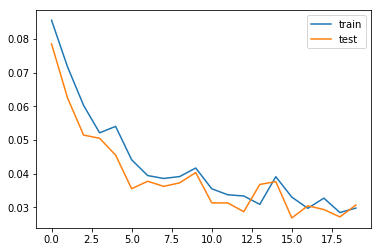

In [286]:
 # design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=1072, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 

In [287]:
# Save the weights
model.save_weights('model_weights.h5')

# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

In [36]:
train_y_m = train_y_m.reshape((train_y_m.shape[0], n_hours, n_features))

test_y_m.shape

test_y_m = test_y_m.reshape((test_y_m.shape[0], n_hours, n_features))

from keras.layers import Dense, Dropout, TimeDistributed, Activation

In [37]:
modelf = Sequential()

modelf.add(LSTM(
    input_shape=(train_X.shape[1], train_X.shape[2]),
    return_sequences=True, units=50))
modelf.add(Dropout(0.2))

modelf.add(LSTM(
    250,
    return_sequences=True))
modelf.add(Dropout(0.2))

modelf.add(TimeDistributed(Dense(train_X.shape[2])))
modelf.add(Activation("linear"))

modelf.compile(loss="mse", optimizer="rmsprop")


In [38]:
train_y_m.shape

(8760, 50, 8)

In [39]:
# fit network
history = modelf.fit(train_X, train_y_m, epochs=30, batch_size=150, validation_data=(test_X, test_y_m), verbose=2, shuffle=False)
# plot history

Train on 8760 samples, validate on 34941 samples
Epoch 1/30
 - 106s - loss: 0.0380 - val_loss: 0.0501
Epoch 2/30
 - 79s - loss: 0.0244 - val_loss: 0.0453
Epoch 3/30
 - 58s - loss: 0.0218 - val_loss: 0.0443
Epoch 4/30
 - 70s - loss: 0.0205 - val_loss: 0.0438
Epoch 5/30
 - 103s - loss: 0.0198 - val_loss: 0.0437
Epoch 6/30
 - 101s - loss: 0.0194 - val_loss: 0.0436
Epoch 7/30
 - 96s - loss: 0.0191 - val_loss: 0.0440
Epoch 8/30
 - 94s - loss: 0.0189 - val_loss: 0.0437
Epoch 9/30
 - 92s - loss: 0.0187 - val_loss: 0.0438
Epoch 10/30
 - 98s - loss: 0.0186 - val_loss: 0.0439
Epoch 11/30
 - 93s - loss: 0.0185 - val_loss: 0.0433
Epoch 12/30
 - 92s - loss: 0.0184 - val_loss: 0.0421
Epoch 13/30
 - 97s - loss: 0.0184 - val_loss: 0.0415
Epoch 14/30
 - 86s - loss: 0.0183 - val_loss: 0.0405
Epoch 15/30
 - 83s - loss: 0.0182 - val_loss: 0.0405
Epoch 16/30
 - 86s - loss: 0.0182 - val_loss: 0.0400
Epoch 17/30
 - 85s - loss: 0.0182 - val_loss: 0.0391
Epoch 18/30
 - 84s - loss: 0.0181 - val_loss: 0.0387
Epo

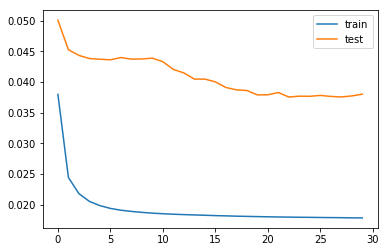

In [40]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [41]:
# Save the weights
modelf.save_weights('model_weightsf50.h5')

# Save the model architecture
with open('model_architecturef50.json', 'w') as f:
    f.write(modelf.to_json())

In [20]:
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('model_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('model_weights.h5')

In [60]:
# make a prediction
yhat = model.predict(test_X)

ValueError: Error when checking : expected lstm_30_input to have shape (768, 8) but got array with shape (50, 8)

In [75]:
scaled.shape

(43800, 8)

In [23]:
yhat.shape

(34270, 1)

In [59]:
test_X_1 = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X_1[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X_1[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [71]:
preds_one_step_m = modelf.predict(test_X)

In [45]:
preds_one_step_m.shape

(34941, 50, 8)

In [120]:
preds_one_step_m_1[:1,:50]

array([[ 8.4198788e-02,  4.7168717e-01,  3.1681490e-01,  5.8097190e-01,
         4.6040887e-01,  6.3662544e-02, -1.1366559e-04, -7.5518282e-04,
         9.3204215e-02,  3.8942575e-01,  2.2946656e-01,  6.3467169e-01,
         4.5344603e-01,  7.5739384e-02,  1.0168802e-03, -2.2956436e-03,
         9.1940731e-02,  3.5960793e-01,  2.0721376e-01,  6.7082477e-01,
         4.6024966e-01,  8.1390381e-02,  1.8985814e-03, -1.7543569e-03,
         8.8159710e-02,  3.4084454e-01,  1.9986463e-01,  6.6710824e-01,
         4.5120752e-01,  8.2522005e-02,  2.6430259e-03, -1.2239190e-03,
         8.3019555e-02,  3.3488041e-01,  2.0108202e-01,  6.6533256e-01,
         4.4493055e-01,  8.2826212e-02,  3.1216145e-03, -1.1975933e-03,
         7.8482017e-02,  3.3583951e-01,  2.1149971e-01,  6.6099495e-01,
         4.4331336e-01,  8.3742648e-02,  3.4091750e-03, -1.1773042e-03,
         7.6137803e-02,  3.3837023e-01]], dtype=float32)

In [116]:
preds_one_step_m_1

array([[ 0.08419879,  0.47168717,  0.3168149 , ...,  0.07532214,
         0.0022921 ,  0.00140906],
       [ 0.08222061,  0.4739729 ,  0.31864345, ...,  0.07542148,
         0.00226328,  0.0011251 ],
       [ 0.0820332 ,  0.47390145,  0.31866688, ...,  0.07701641,
         0.00231987,  0.00111762],
       ...,
       [ 0.09601334,  0.5350995 ,  0.39677194, ...,  0.09521499,
         0.00226866, -0.00115767],
       [ 0.09554075,  0.5234852 ,  0.3794508 , ...,  0.09024769,
         0.00210607, -0.00126808],
       [ 0.09543007,  0.5148083 ,  0.36651823, ...,  0.08470097,
         0.00197911, -0.00123537]], dtype=float32)

In [88]:
preds_one_step_m_1 = preds_one_step_m.reshape((preds_one_step_m.shape[0], n_hours*n_features))
single_preds = preds_one_step_m_1[:,:1]

test_X_1 = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast

test_X_1.shape

(34941, 400)

In [89]:
single_preds.shape

(34941, 1)

In [90]:
test_X_1[:, 1:8].shape

(34941, 7)

In [91]:
preds_one_step_m_1.shape

inv_yhat = concatenate((single_preds, test_X_1[:, 1:8]), axis=1)

In [92]:
inv_yhat.shape

(34941, 8)

In [93]:
inv_yhat = scaler.inverse_transform(inv_yhat)

inv_yhat = inv_yhat[:,0]

In [94]:
# Actuals Inversion
test_y_1 = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y_1, test_X_1[:, -7:]), axis=1)
inv_y_1 = scaler.inverse_transform(inv_y)
inv_y_2 = inv_y_1[:,0]

In [97]:
inv_y_2.shape

(34941,)

In [98]:
inv_yhat.shape

(34941,)

In [104]:
preds_one_step_m.shape

(34941, 50, 8)

In [110]:
dataset.head()

pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0

In [109]:
inv_y_2.max()

array([153., 121.,  77., ..., 112., 128., 164.], dtype=float32)

In [108]:
reframed.head()

var1(t-50)  var2(t-50)  var3(t-50)  var4(t-50)  var5(t-50)  var6(t-50)  \
50    0.129779    0.352941    0.245902    0.527273    0.666667    0.002290   
51    0.148893    0.367647    0.245902    0.527273    0.666667    0.003811   
52    0.159960    0.426471    0.229508    0.545454    0.666667    0.005332   
53    0.182093    0.485294    0.229508    0.563637    0.666667    0.008391   
54    0.138833    0.485294    0.229508    0.563637    0.666667    0.009912   

    var7(t-50)  var8(t-50)  var1(t-49)  var2(t-49)   ...     var7(t-1)  \
50    0.000000         0.0    0.148893    0.367647   ...           0.0   
51    0.000000         0.0    0.159960    0.426471   ...           0.0   
52    0.000000         0.0    0.182093    0.485294   ...           0.0   
53    0.037037         0.0    0.138833    0.485294   ...           0.0   
54    0.074074         0.0    0.109658    0.485294   ...           0.0   

    var8(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
50        0.0  0.025151  0.338235  0.147541  0.600000  0.333333  0.050414   
51        0.0  0.026157  0.323529  0.131148  0.600000  0.333333  0.067214   
52        0.0  0.028169  0.308824  0.131148  0.618183  0.333333  0.082492   
53        0.0  0.026157  0.294118  0.114754  0.636364  0.333333  0.094711   
54        0.0  0.020121  0.279412  0.114754  0.654547  0.333333  0.109989   

    var7(t)  var8(t)  
50      0.0      0.0  
51      0.0      0.0  
52      0.0      0.0  
53      0.0      0.0  
54      0.0      0.0  

[5 rows x 408 columns]

In [102]:
inv_yhat

array([83.693596, 81.727295, 81.54101 , ..., 95.43726 , 94.967514,
       94.85749 ], dtype=float32)

In [100]:
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y_2, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 92.583


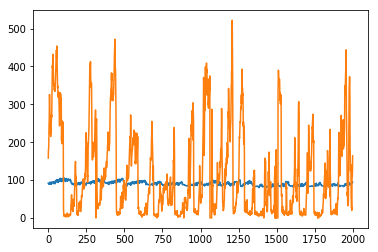

In [114]:

pyplot.plot(inv_yhat[-2000:])
pyplot.plot(inv_y_2[-2000:])
pyplot.show()

In [25]:
### Fuck it here comes the sequence to sequence model
## All I have to do is find a way to make this move. 

In [26]:
test_X.shape

(34270, 768, 8)

In [28]:
import numpy as np
n_future_preds = 30 

preds_moving = []                                    # Use this to store the prediction made on each test window
moving_test_window = [test_X[0,:,:].tolist()]          # Creating the first test window
moving_test_window = np.array(moving_test_window)    # Making it an numpy array

In [31]:
preds_one_step_m.shape

(1, 768, 8)

In [29]:
for i in range(n_future_preds):
    preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
    print(preds_one_step)
    preds_one_step_m = modelf.predict(moving_test_window)
    #moving_test_window_m = [test_X[0,:,:].tolist()]  

    next_pred = preds_one_step_m[:,:1,:]

    next_pred[:,0] = preds_one_step[0][0]

    preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
    preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
    print(preds_one_step.shape)
    print(moving_test_window.shape)
    moving_test_window = np.concatenate((moving_test_window[:,1:,:], next_pred), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end

    

[[0.05803476]]
(1, 1, 1)
(1, 768, 8)
[[0.03402082]]
(1, 1, 1)
(1, 768, 8)
[[0.01755003]]
(1, 1, 1)
(1, 768, 8)
[[0.00566332]]
(1, 1, 1)
(1, 768, 8)
[[-0.0032835]]
(1, 1, 1)
(1, 768, 8)
[[-0.01032566]]
(1, 1, 1)
(1, 768, 8)
[[-0.01611377]]
(1, 1, 1)
(1, 768, 8)
[[-0.02105459]]
(1, 1, 1)
(1, 768, 8)
[[-0.02540139]]
(1, 1, 1)
(1, 768, 8)
[[-0.02931156]]
(1, 1, 1)
(1, 768, 8)
[[-0.03288318]]
(1, 1, 1)
(1, 768, 8)
[[-0.03617805]]
(1, 1, 1)
(1, 768, 8)
[[-0.03923606]]
(1, 1, 1)
(1, 768, 8)
[[-0.04208409]]
(1, 1, 1)
(1, 768, 8)
[[-0.04474139]]
(1, 1, 1)
(1, 768, 8)
[[-0.04722288]]
(1, 1, 1)
(1, 768, 8)
[[-0.0495409]]
(1, 1, 1)
(1, 768, 8)
[[-0.0517064]]
(1, 1, 1)
(1, 768, 8)
[[-0.05372936]]
(1, 1, 1)
(1, 768, 8)
[[-0.05561915]]
(1, 1, 1)
(1, 768, 8)
[[-0.05738466]]
(1, 1, 1)
(1, 768, 8)
[[-0.05903428]]
(1, 1, 1)
(1, 768, 8)
[[-0.06057597]]
(1, 1, 1)
(1, 768, 8)
[[-0.06201721]]
(1, 1, 1)
(1, 768, 8)
[[-0.06336498]]
(1, 1, 1)
(1, 768, 8)
[[-0.06462589]]
(1, 1, 1)
(1, 768, 8)
[[-0.06580597]]
(1,

In [277]:
preds_moving = scaler.inverse_transform(preds_moving)

[[0.01987931]]
(1, 1, 1)
(1, 3, 8)
[[0.02940641]]
(1, 1, 1)
(1, 3, 8)
[[0.03098003]]
(1, 1, 1)
(1, 3, 8)
[[0.0287503]]
(1, 1, 1)
(1, 3, 8)
[[0.02678801]]
(1, 1, 1)
(1, 3, 8)
[[0.02500631]]
(1, 1, 1)
(1, 3, 8)
[[0.02344469]]
(1, 1, 1)
(1, 3, 8)
[[0.02207328]]
(1, 1, 1)
(1, 3, 8)
[[0.02086975]]
(1, 1, 1)
(1, 3, 8)
[[0.01981336]]
(1, 1, 1)
(1, 3, 8)
[[0.01888607]]
(1, 1, 1)
(1, 3, 8)
[[0.01807202]]
(1, 1, 1)
(1, 3, 8)
[[0.01735735]]
(1, 1, 1)
(1, 3, 8)
[[0.01672987]]
(1, 1, 1)
(1, 3, 8)
[[0.01617892]]
(1, 1, 1)
(1, 3, 8)
[[0.01569515]]
(1, 1, 1)
(1, 3, 8)
[[0.01527034]]
(1, 1, 1)
(1, 3, 8)
[[0.0148973]]
(1, 1, 1)
(1, 3, 8)
[[0.01456971]]
(1, 1, 1)
(1, 3, 8)
[[0.01428201]]
(1, 1, 1)
(1, 3, 8)
[[0.01402935]]
(1, 1, 1)
(1, 3, 8)
[[0.01380746]]
(1, 1, 1)
(1, 3, 8)
[[0.01361258]]
(1, 1, 1)
(1, 3, 8)
[[0.01344142]]
(1, 1, 1)
(1, 3, 8)
[[0.01329109]]
(1, 1, 1)
(1, 3, 8)
[[0.01315906]]
(1, 1, 1)
(1, 3, 8)
[[0.0130431]]
(1, 1, 1)
(1, 3, 8)
[[0.01294125]]
(1, 1, 1)
(1, 3, 8)
[[0.01285179]]
(1, 1, 1

ValueError: Expected 2D array, got 1D array instead:
array=[0.01987931 0.02940641 0.03098003 0.0287503  0.02678801 0.02500631
 0.02344469 0.02207328 0.02086975 0.01981336 0.01888607 0.01807202
 0.01735735 0.01672987 0.01617892 0.01569515 0.01527034 0.0148973
 0.01456971 0.01428201 0.01402935 0.01380746 0.01361258 0.01344142
 0.01329109 0.01315906 0.0130431  0.01294125 0.01285179 0.01277321].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [86]:
import numpy as np
def moving_test_window_preds(n_future_preds):

    ''' n_future_preds - Represents the number of future predictions we want to make
                         This coincides with the number of windows that we will move forward
                         on the test data
    '''
    preds_moving = []                                    # Use this to store the prediction made on each test window
    moving_test_window = [test_X[0,:,:].tolist()]          # Creating the first test window
    moving_test_window = np.array(moving_test_window)    # Making it an numpy array
    
    for i in range(n_future_preds):
        preds_one_step = model.predict(moving_test_window) # Note that this is already a scaled prediction so no need to rescale this
        print(preds_one_step)
        
        preds_moving.append(preds_one_step[0,0]) # get the value from the numpy 2D array and append to predictions
        preds_one_step = preds_one_step.reshape(1,1,1) # Reshaping the prediction to 3D array for concatenation with moving test window
        print(preds_one_step.shape)
        print(moving_test_window.shape)
        moving_test_window = np.concatenate((moving_test_window[:,1:,:], preds_one_step), axis=1) # This is the new moving test window, where the first element from the window has been removed and the prediction  has been appended to the end
        
    preds_moving = scaler.inverse_transform(preds_moving)
    
    return preds_moving

In [87]:
preds_moving = moving_test_window_preds(500)

[[0.01977007]]
(1, 1, 1)
(1, 3, 8)


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [70]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 26.294


In [ ]:
pyplot.plot(actuals)
pyplot.plot(preds_moving)
pyplot.show()